# Import library

In [ ]:
!pip install gensim

import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

from wordcloud import WordCloud
from gensim.models import Word2Vec

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Load data

In [ ]:
df = pd.read_csv("Reviews.csv")

# Data Cleaning

In [ ]:
df.shape

(568454, 10)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df = df[['Score', 'Summary', 'Text']]

## Handle Missing Value

In [ ]:
df.dropna()
df.isnull().sum()

,0
Score,0
Summary,27
Text,0


## Drop Duplicates

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

## Drop text length smaller then 10

In [ ]:
df['text_length'] = df['Text'].apply(lambda x: len(str(x).split()))
df = df[df['text_length'] >= 10]
df.shape

(394941, 4)

## Combining Summary and Text into a Single Review Field


In [ ]:
df['Review'] = df['Summary'] + " " + df['Text']
df['Review']

,Review
0,Good Quality Dog Food I have bought several of...
1,Not as Advertised Product arrived labeled as J...
2,"""Delight"" says it all This is a confection tha..."
3,Cough Medicine If you are looking for the secr...
4,Great taffy Great taffy at a great price. The...
...,...
395001,Will not do without Great for sesame chicken.....
395002,disappointed I'm disappointed with the flavor....
395003,Perfect for our maltipoo These stars are small...
395004,Favorite Training and reward treat These are t...


## Mapping Review Scores to Sentiment Labels

In [ ]:
def get_sentiment(score):
    if score >= 4: return "Positive"
    elif score == 3: return "Neutral"
    else: return "Negative"

df['Sentiment'] = df['Score'].apply(get_sentiment)
df[['Score', 'Sentiment']]

,Score,Sentiment
0,5,Positive
1,1,Negative
2,4,Positive
3,2,Negative
4,5,Positive
...,...,...
395001,5,Positive
395002,2,Negative
395003,5,Positive
395004,5,Positive


## Encoding Sentiment Labels into Numerical Values

In [ ]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
df[['Sentiment']].head()

,Sentiment
0,2
1,0
2,2
3,0
4,2


## Creating a Balanced Subsample of Sentiment Classes

In [ ]:
n_samples = 10000
n_per_class = n_samples // 3

df_0 = df[df['Sentiment'] == 0].sample(n=n_per_class, random_state=42)
df_1 = df[df['Sentiment'] == 1].sample(n=n_per_class, random_state=42)
df_2 = df[df['Sentiment'] == 2].sample(n=n_samples - n_per_class * 2, random_state=42)

df = pd.concat([df_0, df_1, df_2]).sample(frac=1, random_state=42)

df['Sentiment'].value_counts()

,count
Sentiment,
2,3334
1,3333
0,3333


## Normalize Text

In [ ]:
# Make text lowercase and remove punctuation, symbols, and numbers
def normalize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['Cleaned_Review'] = df['Review'].fillna("").apply(normalize)
df['Cleaned_Review']

,Cleaned_Review
92532,crystal light normaly good this one not so muc...
329069,not very happy these were ok but i was not hap...
362252,drastically overpriced item this product is dr...
229464,cheaper at the sams club or bj this cereal is ...
204379,the shipment i received had older beans well t...
...,...
219327,nice aroma smells great but there is little of...
140547,was ok it was ok just not what i was expecting...
277442,great dog food update they just raised the pr...
119528,dont bother i wouldnt call this flaked it is m...


## Tokenize Text

In [ ]:
# Split sentences into words (tokens)
def tokenize(text):
    return word_tokenize(text)

df['Cleaned_Review'] = df['Cleaned_Review'].apply(tokenize)
df['Cleaned_Review']

,Cleaned_Review
92532,"[crystal, light, normaly, good, this, one, not..."
329069,"[not, very, happy, these, were, ok, but, i, wa..."
362252,"[drastically, overpriced, item, this, product,..."
229464,"[cheaper, at, the, sams, club, or, bj, this, c..."
204379,"[the, shipment, i, received, had, older, beans..."
...,...
219327,"[nice, aroma, smells, great, but, there, is, l..."
140547,"[was, ok, it, was, ok, just, not, what, i, was..."
277442,"[great, dog, food, update, they, just, raised,..."
119528,"[dont, bother, i, wouldnt, call, this, flaked,..."


## Remove Stopwords

In [ ]:
# Remove common English words like "the", "is", "a", etc.
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['Cleaned_Review'] = df['Cleaned_Review'].apply(remove_stopwords)
df['Cleaned_Review']

,Cleaned_Review
92532,"[crystal, light, normaly, good, one, much, pro..."
329069,"[happy, ok, happy, several, reasonsbr, br, rec..."
362252,"[drastically, overpriced, item, product, drast..."
229464,"[cheaper, sams, club, bj, cereal, best, ive, t..."
204379,"[shipment, received, older, beans, well, first..."
...,...
219327,"[nice, aroma, smells, great, little, wonders, ..."
140547,"[ok, ok, expecting, wont, say, yes, try]"
277442,"[great, dog, food, update, raised, price, anot..."
119528,"[dont, bother, wouldnt, call, flaked, disgusti..."


## Lemmatize Tokens

In [ ]:
# Convert words to their base form (e.g., "running" → "run")
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['Cleaned_Review'] = df['Cleaned_Review'].apply(lemmatize)
df['Cleaned_Review']

,Cleaned_Review
92532,"[crystal, light, normaly, good, one, much, pro..."
329069,"[happy, ok, happy, several, reasonsbr, br, rec..."
362252,"[drastically, overpriced, item, product, drast..."
229464,"[cheaper, sam, club, bj, cereal, best, ive, tr..."
204379,"[shipment, received, older, bean, well, first,..."
...,...
219327,"[nice, aroma, smell, great, little, wonder, fo..."
140547,"[ok, ok, expecting, wont, say, yes, try]"
277442,"[great, dog, food, update, raised, price, anot..."
119528,"[dont, bother, wouldnt, call, flaked, disgusti..."


## Join Tokens Back into Text

In [ ]:
# You can create a final cleaned text column by joining the lemmatized tokens back into a single string
df['Cleaned_Review'] = df['Cleaned_Review'].apply(lambda tokens: ' '.join(tokens))
df['Cleaned_Review']

,Cleaned_Review
92532,crystal light normaly good one much product co...
329069,happy ok happy several reasonsbr br recently t...
362252,drastically overpriced item product drasticall...
229464,cheaper sam club bj cereal best ive tried far ...
204379,shipment received older bean well first time u...
...,...
219327,nice aroma smell great little wonder found aro...
140547,ok ok expecting wont say yes try
277442,great dog food update raised price another mer...
119528,dont bother wouldnt call flaked disgusting gro...


# Build Model (TF-IDF + Logistic Regression)

## Selecting Features and Labels for Model Training


In [ ]:
X = df['Cleaned_Review'].values
y = df['Sentiment'].values

## 5-Fold Cross-Validation using TF-IDF and Logistic Regression


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recs, f1s = [], [], [], []
all_y_true, all_y_pred = [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold}:")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")


Fold 1:
Accuracy : 0.6775
Precision: 0.6778
Recall   : 0.6776
F1-Score : 0.6774

Fold 2:
Accuracy : 0.6895
Precision: 0.6878
Recall   : 0.6895
F1-Score : 0.6885

Fold 3:
Accuracy : 0.6955
Precision: 0.6968
Recall   : 0.6955
F1-Score : 0.6959

Fold 4:
Accuracy : 0.6860
Precision: 0.6881
Recall   : 0.6860
F1-Score : 0.6869

Fold 5:
Accuracy : 0.6685
Precision: 0.6676
Recall   : 0.6684
F1-Score : 0.6679


## Average Evaluation Metrics

In [ ]:
print("\nAverage Evaluation Metrics")
print(f"Accuracy : {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall   : {np.mean(recs):.4f}")
print(f"F1-Score : {np.mean(f1s):.4f}")


Average Evaluation Metrics
Accuracy : 0.6834
Precision: 0.6836
Recall   : 0.6834
F1-Score : 0.6833


## Classification Report

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']

print(classification_report(all_y_true, all_y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.69      0.70      0.69      3333
     Neutral       0.59      0.59      0.59      3333
    Positive       0.77      0.77      0.77      3334

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



## Confusion Matrix

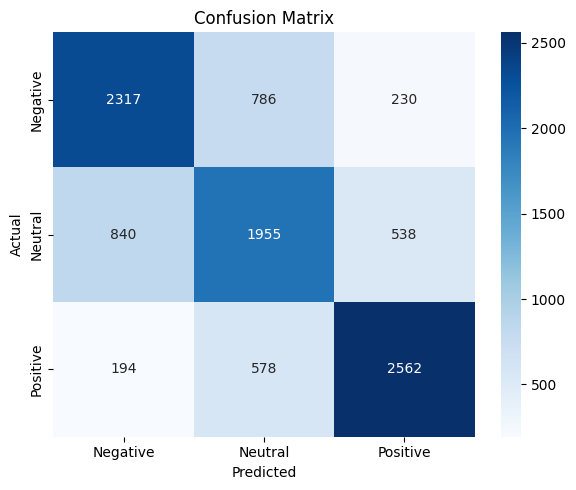

In [ ]:
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Exporting TF-IDF + Logistic Regression Predictions to CSV


In [ ]:
result_df = pd.DataFrame({
    'Review': X,
    'True': all_y_true,
    'Predicted': all_y_pred
})

le = LabelEncoder()
le.fit(df['Sentiment'])

result_df['True'] = le.inverse_transform(result_df['True'])
result_df['Predicted'] = le.inverse_transform(result_df['Predicted'])

label_map = {i: label for i, label in enumerate(['Negative', 'Neutral', 'Positive'])}
result_df['Predicted_Label'] = result_df['Predicted'].map(label_map)

result_df.to_csv("predicted_reviews_ml.csv", index=False)

## Visualizing Predicted Sentiment Distribution


/tmp/ipython-input-26-4090033899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=result_df, x='Predicted_Label', order=['Negative', 'Neutral', 'Positive'], palette='pastel')


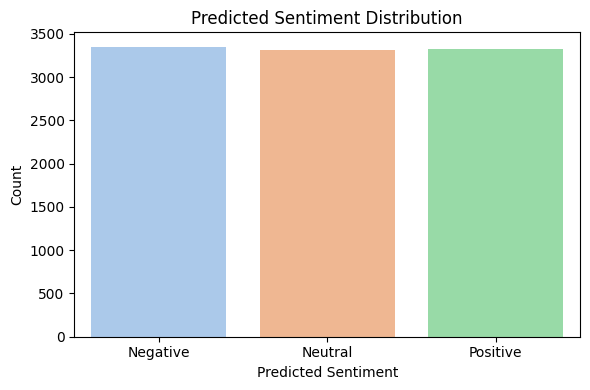

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=result_df, x='Predicted_Label', order=['Negative', 'Neutral', 'Positive'], palette='pastel')
plt.title('Predicted Sentiment Distribution')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Generating Word Clouds for Predicted Sentiments


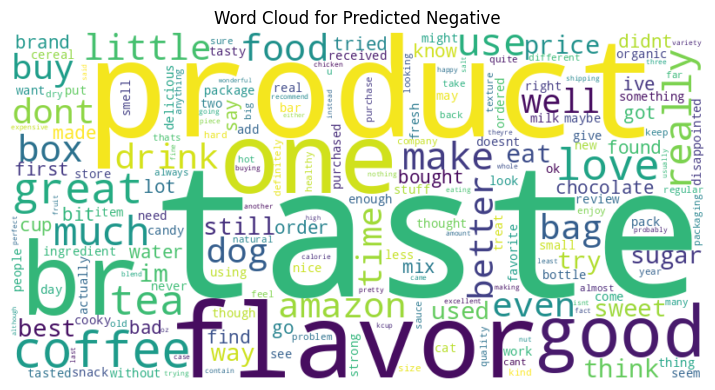

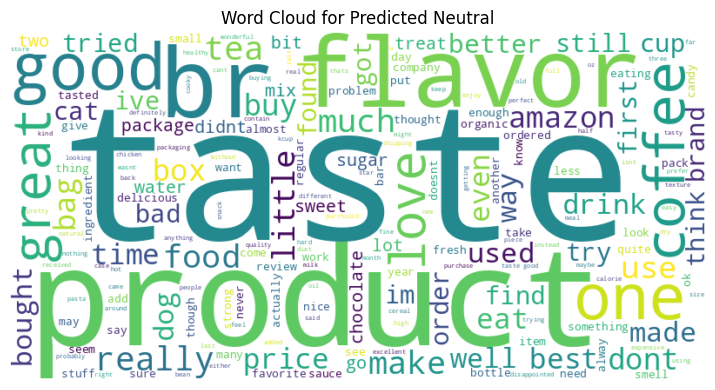

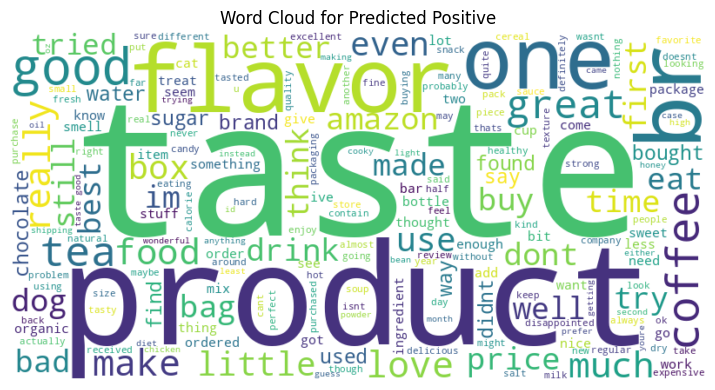

In [ ]:
for sentiment in ['Negative', 'Neutral', 'Positive']:
    text = ' '.join(result_df[result_df['Predicted_Label'] == sentiment]['Review'])
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Predicted {sentiment}')
        plt.tight_layout()
        plt.show()


# Build Model (Word2Vec + BiLSTM)

## Preparing Texts and Labels


In [ ]:
texts = df['Cleaned_Review'].astype(str).tolist()
labels = df['Sentiment'].tolist()

le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

tokenized_texts = [text.split() for text in texts]

## Training Word2Vec Embeddings on Tokenized Reviews


In [ ]:
embedding_dim = 200

w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=embedding_dim, window=5, min_count=2, workers=4)
word_vectors = w2v_model.wv
vocab = word_vectors.key_to_index

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

In [ ]:
def build_bilstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=200,
                        trainable=True))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

## 5-Fold Cross-Validation

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1s, accs, precs, recs = [], [], [], []
all_y_true = []
all_y_pred = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_pad, y)):
    print(f"\nFold {fold + 1}")

    model = build_bilstm_model()
    model.fit(X_pad[train_idx], y_cat[train_idx],
              epochs=10,
              batch_size=64,
              validation_data=(X_pad[val_idx], y_cat[val_idx]),
              callbacks=[early_stop],
              verbose=1)

    preds = model.predict(X_pad[val_idx])
    preds_labels = np.argmax(preds, axis=1)
    true_labels = y[val_idx]

    acc = accuracy_score(true_labels, preds_labels)
    prec = precision_score(true_labels, preds_labels, average='macro')
    rec = recall_score(true_labels, preds_labels, average='macro')
    f1 = f1_score(true_labels, preds_labels, average='macro')

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

    all_y_true.extend(true_labels)
    all_y_pred.extend(preds_labels)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.4738 - loss: 1.0059 - val_accuracy: 0.5760 - val_loss: 0.8880
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.6364 - loss: 0.8016 - val_accuracy: 0.6455 - val_loss: 0.7700
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7649 - loss: 0.5810 - val_accuracy: 0.6670 - val_loss: 0.7517
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8792 - loss: 0.3272 - val_accuracy: 0.6330 - val_loss: 1.0369
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9580 - loss: 0.1363 - val_accuracy: 0.6335 - val_loss: 1.2081
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 337ms/step
Accuracy : 0.6670
Precision: 0.6652
Recall   : 0.6670
F1-Score : 0.6659

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.5029 - loss: 0.9861 - val_accuracy: 0.5895 - val_loss: 0.8587
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.6352 - loss: 0.7938 - val_accuracy: 0.6410 - val_loss: 0.7807
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7647 - loss: 0.5676 - val_accuracy: 0.6660 - val_loss: 0.7822
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8807 - loss: 0.3305 - val_accuracy: 0.6290 - val_loss: 1.1567
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step
Accuracy : 0.6410
Precision: 0.6318
Recall   : 0.6410
F1-Score : 0.6237

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.4796 - loss: 1.0042 - val_accuracy: 0.5630 - val_loss: 0.9200
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.6070 - loss: 0.8379 - val_accuracy: 0.6455 - val_loss: 0.7773
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7330 - loss: 0.6318 - val_accuracy: 0.6710 - val_loss: 0.7359
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8571 - loss: 0.3744 - val_accuracy: 0.6650 - val_loss: 0.8379
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9430 - loss: 0.1787 - val_accuracy: 0.6430 - val_loss: 1.1448
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step
Accuracy : 0.6710
Precision: 0.6673
Recall   : 0.6711
F1-Score : 0.6563

Fold 4
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.4776 - loss: 0.9942 - val_accuracy: 0.5935 - val_loss: 0.8667
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.6387 - loss: 0.7939 - val_accuracy: 0.6480 - val_loss: 0.7603
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.7193 - loss: 0.6379 - val_accuracy: 0.6565 - val_loss: 0.7674
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8568 - loss: 0.3690 - val_accuracy: 0.6675 - val_loss: 0.9044
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 365ms/step
Accuracy : 0.6480
Precision: 0.6617
Recall   : 0.6478
F1-Score : 0.6168

Fold 5
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.4772 - loss: 1.0103 - val_accuracy: 0.5925 - val_loss: 0.8602
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.6357 - loss: 0.8031 - val_accuracy: 0.6345 - val_loss: 0.7931
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.7448 - loss: 0.6154 - val_accuracy: 0.6545 - val_loss: 0.7829
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.8640 - loss: 0.3536 - val_accuracy: 0.6510 - val_loss: 0.9216
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9532 - loss: 0.1475 - val_accuracy: 0.6185 - val_loss: 1.2839
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step
Accuracy : 0.6545
Precision: 0.6817
Recall   : 0.6545
F1-Score : 0.6606


## Average Evaluation Metrics

In [ ]:
print("\nAverage Evaluation Metrics")
print(f"Accuracy : {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall   : {np.mean(recs):.4f}")
print(f"F1-Score : {np.mean(f1s):.4f}")


Average Evaluation Metrics
Accuracy : 0.6563
Precision: 0.6615
Recall   : 0.6563
F1-Score : 0.6446


## Classification Report

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']

print(classification_report(all_y_true, all_y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.64      0.73      0.69      3333
     Neutral       0.58      0.46      0.51      3333
    Positive       0.73      0.78      0.75      3334

    accuracy                           0.66     10000
   macro avg       0.65      0.66      0.65     10000
weighted avg       0.65      0.66      0.65     10000



## Confusion Matrix

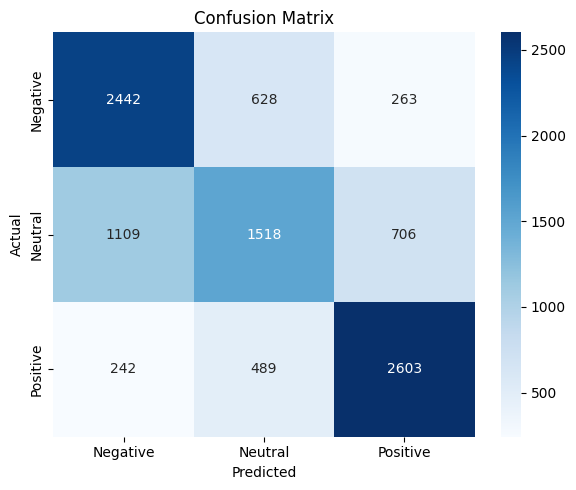

In [ ]:
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Saving Test Predictions to CSV for Evaluation and Visualization

In [ ]:
result_df = pd.DataFrame({
    'Review': X,
    'True': all_y_true,
    'Predicted': all_y_pred
})

le = LabelEncoder()
le.fit(df['Sentiment'])

result_df['True'] = le.inverse_transform(result_df['True'])
result_df['Predicted'] = le.inverse_transform(result_df['Predicted'])

label_map = {i: label for i, label in enumerate(['Negative', 'Neutral', 'Positive'])}
result_df['Predicted_Label'] = result_df['Predicted'].map(label_map)

result_df.to_csv("predicted_reviews_dl.csv", index=False)

/tmp/ipython-input-37-4090033899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=result_df, x='Predicted_Label', order=['Negative', 'Neutral', 'Positive'], palette='pastel')


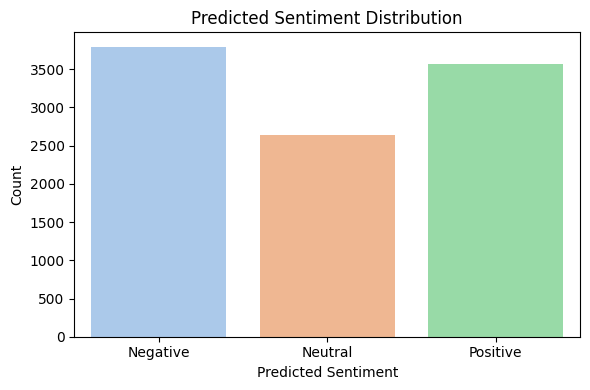

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=result_df, x='Predicted_Label', order=['Negative', 'Neutral', 'Positive'], palette='pastel')
plt.title('Predicted Sentiment Distribution')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

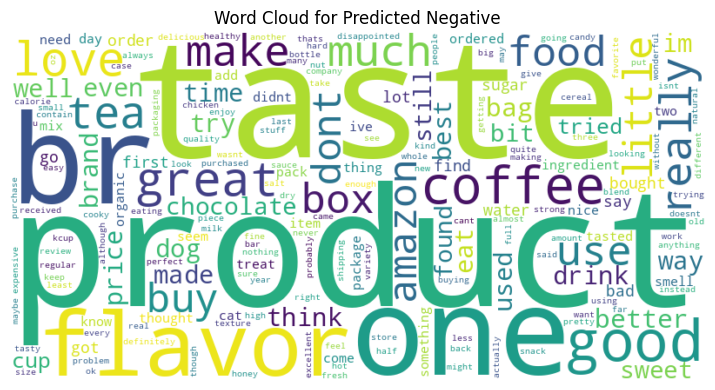

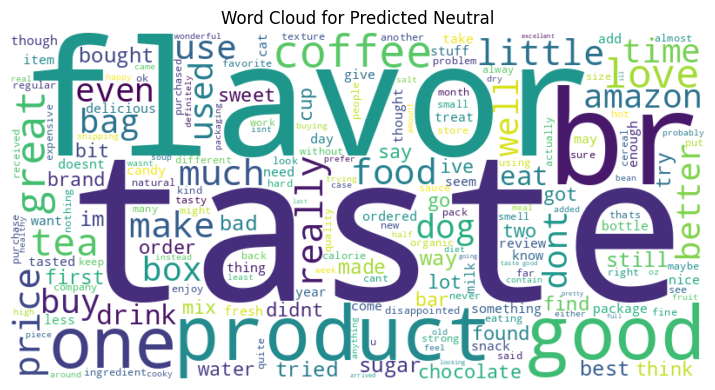

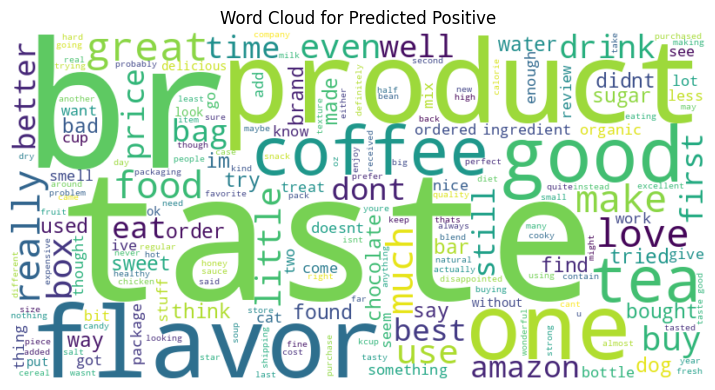

In [ ]:
for sentiment in ['Negative', 'Neutral', 'Positive']:
    text = ' '.join(result_df[result_df['Predicted_Label'] == sentiment]['Review'])
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Predicted {sentiment}')
        plt.tight_layout()
        plt.show()

# Future Work

For machine learning models, future improvements can focus on advanced feature engineering and ensemble methods. Although Logistic Regression with TF–IDF achieved the best performance in this study, the feature representation could be enhanced using n-gram selection, chi-squared feature ranking, or term weighting techniques like BM25. Additionally, exploring ensemble classifiers such as Random Forests or Gradient Boosted Trees could yield performance gains by capturing nonlinear patterns that single linear models may miss. Incorporating metadata (e.g., review length, helpfulness scores) as additional input features may also contribute to improved classification accuracy.


In the case of deep learning models, particularly the BiLSTM architecture, future work should aim to increase the dataset size and balance class distributions—especially for the underperforming neutral class. The model’s effectiveness can also be enhanced by integrating attention mechanisms to help the network focus on sentiment-relevant tokens in long sequences. Moreover, replacing Word2Vec with contextual embeddings (e.g., ELMo or BERT embeddings) could help the model better handle polysemous words and improve generalization across varying review structures. Hyperparameter tuning with techniques such as Random Search or Bayesian Optimization could further optimize the BiLSTM’s performance.